In [1]:
import sagemaker
import numpy as np
import boto3
import os
import pandas as pd
import io
from sklearn import datasets
from sagemaker import get_execution_role

role = get_execution_role()

iris = datasets.load_iris()
prefix='mlops/iris'
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
model_name = open('model_name.txt', 'r').read().strip() if os.path.isfile('model_name.txt') else None
if model_name is None:
    raise Exception("You must run Part 1 or 2 before this. There you will train a Model to use here")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
import sagemaker
import numpy as np
import boto3
import os
from sklearn import datasets
from sagemaker import get_execution_role

# Get SageMaker role and session
role = get_execution_role()
boto3.setup_default_session(region_name='us-east-1')  # Ensure correct region
sagemaker_session = sagemaker.Session()

# Default bucket and prefix
prefix = 'mlops/iris'
bucket = sagemaker_session.default_bucket()

# Load the model name from the file
model_name_file = 'model_name.txt'
if not os.path.isfile(model_name_file):
    raise FileNotFoundError(f"{model_name_file} not found. Train a model first.")
with open(model_name_file, 'r') as f:
    model_name = f.read().strip()

# Validate the model exists
sagemaker_client = boto3.client('sagemaker')
try:
    response = sagemaker_client.describe_model(ModelName=model_name)
    print(f"Model '{model_name}' found and ready for use.")
except sagemaker_client.exceptions.ClientError:
    raise Exception(f"Model '{model_name}' does not exist. Verify the model name or train a new model.")

# Load dataset and set up batch transform
iris = datasets.load_iris()
batch_dataset_filename = "batch_dataset.csv"
np.savetxt(batch_dataset_filename, iris.data, delimiter=",", fmt='%0.3f')
input_batch = sagemaker_session.upload_data(path=batch_dataset_filename, key_prefix=f'{prefix}/data')

print(f"Batch dataset uploaded to: {input_batch}")


Model 'sagemaker-xgboost-2025-01-11-12-59-33-677' found and ready for use.
Batch dataset uploaded to: s3://sagemaker-us-east-1-853973692277/mlops/iris/data/batch_dataset.csv


In [3]:
batch_dataset_filename="batch_dataset.csv"
np.savetxt(batch_dataset_filename, iris.data, delimiter=",", fmt='%0.3f')
input_batch = sagemaker_session.upload_data(path=batch_dataset_filename, key_prefix='%s/data' % prefix)

In [4]:
# Initialize the transformer object
transformer=sagemaker.transformer.Transformer(
    base_transform_job_name='mlops-iris',
    model_name=model_name,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    output_path='s3://{}/{}/batch_output'.format(bucket, prefix),
)
# To start a transform job:
transformer.transform(input_batch, content_type='text/csv', split_type='Line')
# Then wait until transform job is completed
transformer.wait()

INFO:sagemaker:Creating transform job with name: mlops-iris-2025-01-12-04-08-13-186


..................................[2025-01-12:04:13:53:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-12:04:13:53:INFO] No GPUs detected (normal if no gpus installed)
[2025-01-12:04:13:53:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2025-01-12 04:13:54 +0000] [19] [INFO] Starting g

In [5]:
dataset = np.insert(iris.data, 0, iris.target,axis=1)
df = pd.DataFrame(data=dataset, columns=['iris_id'] + iris.feature_names)
df_pred = pd.read_csv(
    io.StringIO(sagemaker_session.read_s3_file(bucket, '{}/batch_output/{}.out'.format(
        prefix, batch_dataset_filename))), names=['predicted_iris_id'] )
df = pd.merge(df,df_pred, left_index=True, right_index=True)
df.head()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),predicted_iris_id
0,0.0,5.1,3.5,1.4,0.2,0.0
1,0.0,4.9,3.0,1.4,0.2,0.0
2,0.0,4.7,3.2,1.3,0.2,0.0
3,0.0,4.6,3.1,1.5,0.2,0.0
4,0.0,5.0,3.6,1.4,0.2,0.0


In [6]:
from sklearn.metrics import f1_score
score = f1_score(df['iris_id'], df['predicted_iris_id'],labels=[0.0,1.0,2.0],average='micro')

print('F1 Score(micro): %.1f' % (score * 100.0))


F1 Score(micro): 96.0


/tmp/ipykernel_12592/3055998515.py:9: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  sns.heatmap(cnf_matrix, annot=True, fmt="f", mask=np.zeros_like(cnf_matrix, dtype=np.bool),


AttributeError: module 'numpy' has no attribute 'bool'.
`np.bool` was a deprecated alias for the builtin `bool`. To avoid this error in existing code, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

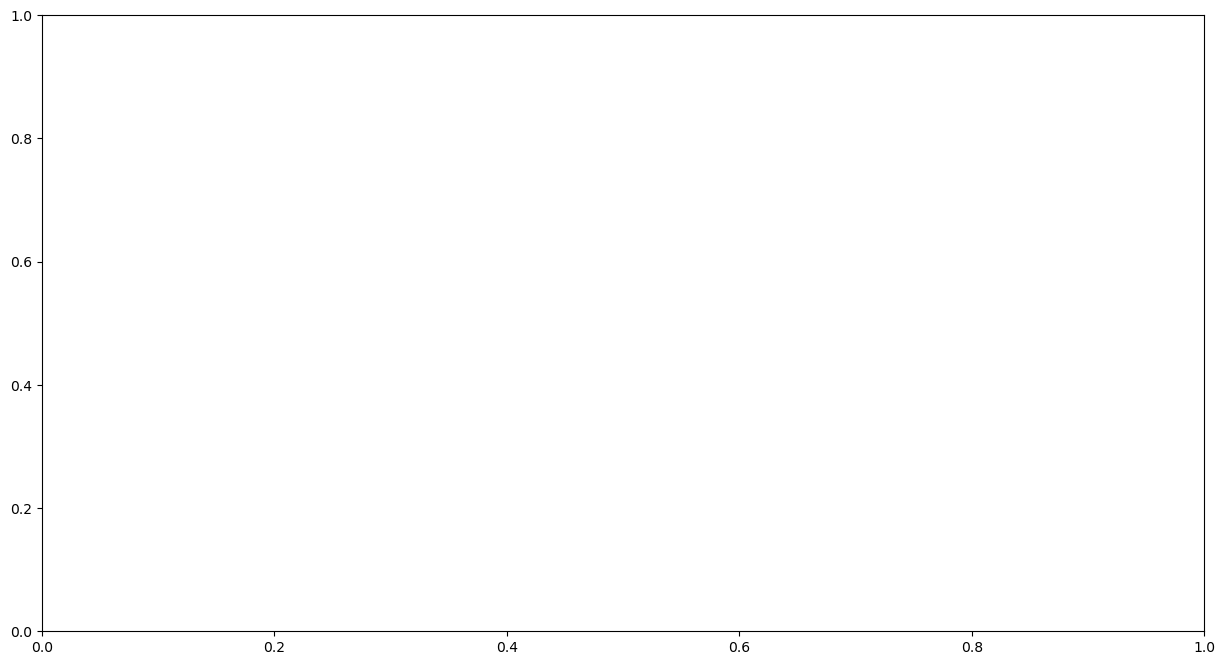

In [7]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(df['iris_id'], df['predicted_iris_id'])

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(cnf_matrix, annot=True, fmt="f", mask=np.zeros_like(cnf_matrix, dtype=np.bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

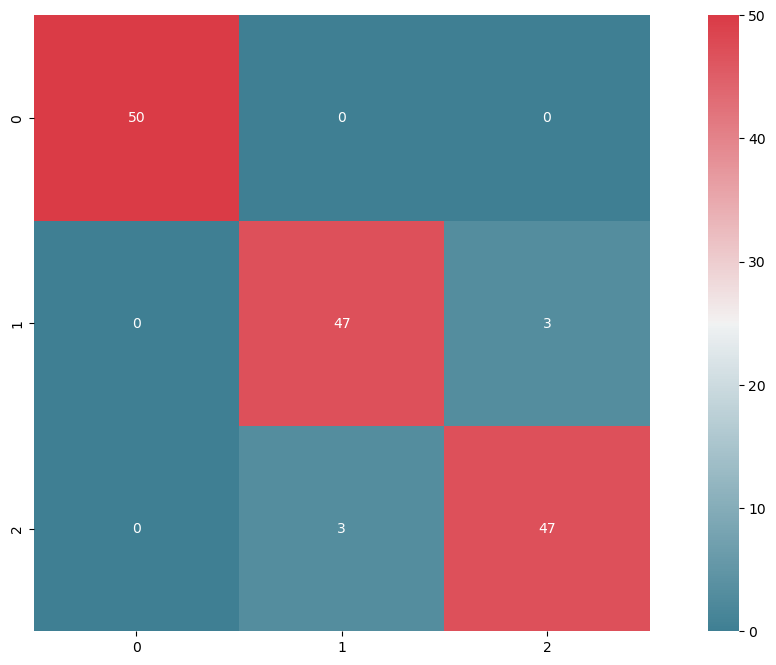

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming df is already defined
cnf_matrix = confusion_matrix(df['iris_id'], df['predicted_iris_id'])

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(cnf_matrix, annot=True, fmt="d", mask=np.zeros_like(cnf_matrix, dtype=bool), 
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

plt.show()
